# Image classification using Resnet50

In [42]:
import os
import xml.etree.ElementTree as ET
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

### Load Dataset

In [43]:
CLASS_LABEL_MAP = {'crosswalk': 0, 'speedlimit': 1, 'stop': 2, 'trafficlight': 3}

In [44]:
def load_dataset():
    # directory paths
    img_dir = "Dataset/images"
    ann_dir = "Dataset/annotations"

    images = []
    labels = []

    for img_name in os.listdir(img_dir):
        # Load image
        img_path = os.path.join(img_dir, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image) # Normalize for ResNet

        # Load corresponding annotation
        ann_path = os.path.join(ann_dir, img_name.replace('.png', '.xml'))
        tree = ET.parse(ann_path)
        root = tree.getroot()
        label = root.find("object").find("name").text  # Extract object label

        images.append(image)
        labels.append(CLASS_LABEL_MAP[label]) # Convert string label to numeric

    return np.array(images), np.array(labels)

In [45]:
X, y = load_dataset()

In [46]:
X.shape, y.shape

((877, 224, 224, 3), (877,))

### Train-test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
X_train.shape, X_test.shape

((701, 224, 224, 3), (176, 224, 224, 3))

### Model Training

In [49]:
# Model definition

resnet_model = Sequential()

pretrained_model = ResNet50(
    include_top=False,
    input_shape = (224, 224, 3),
    pooling='avg',
    classes=4,
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

In [50]:
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [51]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [52]:
# Model training
history = resnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 71s 733ms/step - accuracy: 0.7335 - loss: 1.2599 - val_accuracy: 0.7841 - val_loss: 0.8820
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 67s 763ms/step - accuracy: 0.9164 - loss: 0.3384 - val_accuracy: 0.8750 - val_loss: 0.6068
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 60s 682ms/step - accuracy: 0.9556 - loss: 0.1178 - val_accuracy: 0.8352 - val_loss: 0.6174
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 62s 708ms/step - accuracy: 0.9637 - loss: 0.1082 - val_accuracy: 0.8295 - val_loss: 0.8834
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 752ms/step - accuracy: 0.9810 - loss: 0.0561 - val_accuracy: 0.8523 - val_loss: 0.6103


### Model Evaluation

In [53]:
# Test accuracy
resnet_model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8787 - loss: 0.5701


[0.6103149056434631, 0.8522727489471436]

In [54]:
y_predicted = resnet_model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


In [55]:
# Converting probabilities to discrete integers
y_predicted = [np.argmax(element) for element in y_predicted]
y_predicted[:5]

[1, 2, 1, 2, 1]

In [56]:
print(classification_report(y_test, y_predicted, target_names=CLASS_LABEL_MAP.keys()))

              precision    recall  f1-score   support

   crosswalk       0.58      0.64      0.61        22
  speedlimit       0.90      0.93      0.91       120
        stop       0.89      0.73      0.80        22
trafficlight       0.82      0.75      0.78        12

    accuracy                           0.85       176
   macro avg       0.80      0.76      0.78       176
weighted avg       0.86      0.85      0.85       176



Text(45.722222222222214, 0.5, 'Truth')

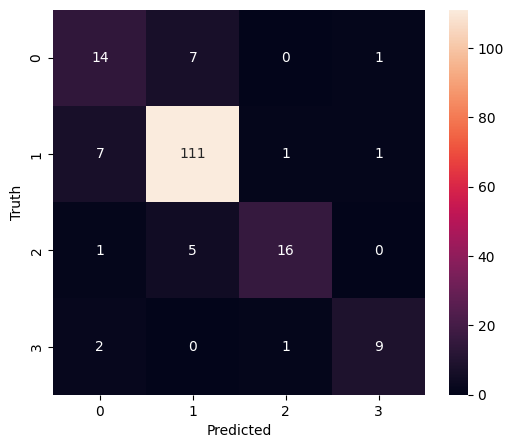

In [57]:
cm = confusion_matrix(y_test, y_predicted)

plt.figure(figsize = (6,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')